### Configurable Variables
Variables that can be modified in this notebook
- `input_data` — path to the input folder containing the dataset
- `lib_th` — threshold for the **total library size** (minimum number of reads or counts per cell)
- `gene_th` — threshold for the **number of genes expressed** per cell
- `mito_th` — threshold for the **percentage or number of mitochondrial genes expressed** per cell
- `cell_th` — threshold for the **minimum number of cells in which a gene must be expressed** to be retained in the analysis
- `bins` — **number of bins** or intervals used for data visualization, normalization, or distribution analysis
- `supress_warnings` — boolean flag to enable/disable warning messages (`True`/`False`)
---
**Set following variables if you are running notebook interactively.**

In [1159]:
input_path_default = "data/SN124_A798015_Rep2"
lib_th_default = 1000
gene_th_default = 750
mito_th_default = 18
cell_th_default = 10
bins_default = 50
suppress_warnings_default = False

# SPATIAL TRANSCRIPTOMICS – QC ANALYSIS

This script performs basic **quality control** of spatial transcriptomics data
(Visium 10x Genomics) in Python using the **Scanpy** library.



### Load variables from CMD

In [1160]:
SUPPRESS_WARNINGS = None
try:
    if suppress_warnings == "True":
        SUPPRESS_WARNINGS = True
    else:
        SUPPRESS_WARNINGS = False
except NameError:
    SUPPRESS_WARNINGS = suppress_warnings_default

try:
    LIB_TH = lib_th
except NameError:
    LIB_TH = lib_th_default

try:
    GENE_TH = gene_th
except NameError:
    GENE_TH = gene_th_default

try:
    MITO_TH = mito_th
except NameError:
    MITO_TH = mito_th_default

try:
    CELL_TH = cell_th
except NameError:
    CELL_TH = cell_th_default

try:
    BIN_SIZE = bins
except NameError:
    BIN_SIZE = bins_default



## Suppress Warnings (Optional)

* Suppress warnings for cleaner output.  
* Comment out the line below if warnings are desired for debugging.

In [1161]:
# Suppress warnings for cleaner output
import warnings
import os

if SUPPRESS_WARNINGS:
    print("Ignoring warnings.")
    warnings.filterwarnings('ignore')

### Environment setup

1. Install the necessary packages using `pip` if they are not already installed:

In [1162]:
!pip install scanpy squidpy --quiet


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


2. Import necessary libraries:

In [1163]:
# Import of libraries for working with spatial transcriptomics data
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
import squidpy as sq
from matplotlib.colors import ListedColormap
import sys

3. load the dataset
  * **Option 1**: Import data directly from Google Drive (requires Google Colab).
  * **Option 2**: Load dataset path from CMD.

In [1164]:
# OPTION 1
# from google.colab import drive
# drive.mount('/content/drive')

In [1165]:
# OPTION 2
DATA_PATH = None
try:
    DATA_PATH = input_data
except NameError:
    DATA_PATH = input_path_default

if DATA_PATH is None or not os.path.exists(DATA_PATH):
    print("ERROR: Datapath (", DATA_PATH ,") not found.")
    sys.exit()

print("Using input path:", DATA_PATH)

DATA_FOLDER_NAME = DATA_PATH.split("/")[-1].strip()

save_dir = "figures/show/qc/" + DATA_FOLDER_NAME
os.makedirs(save_dir, exist_ok=True)

Using input path: data/SN124_A798015_Rep2


# QC analaysis

**2.1.1 Plot tissue map**

The input folder contains outputs from the 10x Genomics Space Ranger pipeline:  
- `filtered_feature_bc_matrix.h5` → filtered expression data  
- `spatial/` → contains the file `tissue_positions_list.csv` with spot positions

In [1166]:
# Basic information about the dataset
adata = sc.read_visium(DATA_PATH)
print(adata)

print("Number of spots:", adata.n_obs)

print("Number of genes:", adata.n_vars)

print("Available variables in metadata (obs):", adata.obs.columns.tolist())


/var/folders/n1/v7nxdxqs1qq7ck0bphkynr1c0000gp/T/ipykernel_2093/3313572494.py:2: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(DATA_PATH)
/Users/polakova/PycharmProjects/IV114_ST/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/polakova/PycharmProjects/IV114_ST/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 1656 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
Number of spots: 1656
Number of genes: 36601
Available variables in metadata (obs): ['in_tissue', 'array_row', 'array_col']


/var/folders/n1/v7nxdxqs1qq7ck0bphkynr1c0000gp/T/ipykernel_2093/708384831.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


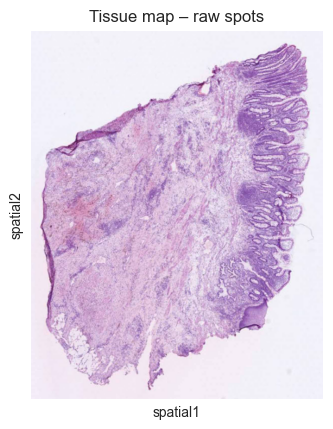

/var/folders/n1/v7nxdxqs1qq7ck0bphkynr1c0000gp/T/ipykernel_2093/708384831.py:13: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


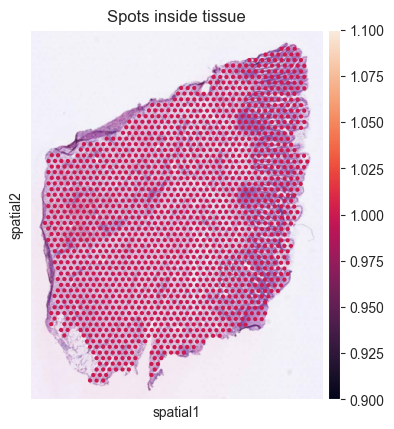

In [1167]:
# Basic map of spots (without colors)
sc.pl.spatial(
    adata,
    color=None,
    size=1.3,
    title="Tissue map – raw spots",
    save=os.path.join("/qc/" + DATA_FOLDER_NAME + "/", "tissue_map.png")
)

# The dataset contains a tissue annotation 'in_tissue', which can be displayed in color:
if "in_tissue" in adata.obs.columns:
    # Display a spatial plot for the selected QC metric within the tissue
    sc.pl.spatial(
        adata,
        color="in_tissue",
        title="Spots inside tissue",
        save=os.path.join("/qc/" + DATA_FOLDER_NAME + "/", "spots_in_tissue.png")
    )


**2.1.2 Calculating QC metrics**

Mitochondrial genes are usually labeled with the prefix “MT-”. These genes serve as indicators of cell integrity — a high proportion of mitochondrial transcripts often indicates damaged or dying cells.

In [1168]:
# Identification of mitochondrial genes based on the 'MT-' prefix
# In the AnnData object used by Scanpy, gene information is stored in adata.var
adata.var["mt"] = adata.var_names.str.startswith("MT-")

In [1169]:
# Display the first ten genes identified as mitochondrial
# Used to verify that the detection worked correctly
print("First 10 mitochondrial genes:")
print(adata.var_names[adata.var["mt"]][:10].tolist())


First 10 mitochondrial genes:
['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4']


In [1170]:
# The calculate_qc_metrics function adds standard QC variables to the metadata (obs):
# - total_counts: total number of transcripts per spot
# - n_genes_by_counts: number of genes detected per spot
# - pct_counts_mt: percentage of mitochondrial transcripts
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

In [1171]:
# Overview of available QC metrics in adata.obs
print("\nAvailable QC metrics:")
print([col for col in adata.obs.columns if "count" in col or "gene" in col or "mt" in col])


Available QC metrics:
['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt']


In [1172]:
# Display the first few rows of QC metrics stored for individual spots
print("Example of calculated QC metrics (adata.obs):")
print(adata.obs.head())

Example of calculated QC metrics (adata.obs):
                    in_tissue  array_row  array_col  n_genes_by_counts  \
AAACAGAGCGACTCCT-1          1         14         94               6598   
AAACCGGGTAGGTACC-1          1         42         28               1161   
AAACCGTTCGTCCAGG-1          1         52         42               1632   
AAACCTCATGAAGTTG-1          1         37         19               1660   
AAACGAGACGGTTGAT-1          1         35         79               2263   

                    log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
AAACAGAGCGACTCCT-1                 8.794673       36824.0           10.513932   
AAACCGGGTAGGTACC-1                 7.057898        2503.0            7.825645   
AAACCGTTCGTCCAGG-1                 7.398174        3781.0            8.238008   
AAACCTCATGAAGTTG-1                 7.415175        3587.0            8.185350   
AAACGAGACGGTTGAT-1                 7.724888        6434.0            8.769507   

                    pc


**2.1.3 Library size threshold plot**

One of the problems with spatial transcriptomics data are spots with low gene expression. During this QC step we want to remove those spots, as it may indicate poor outputs.

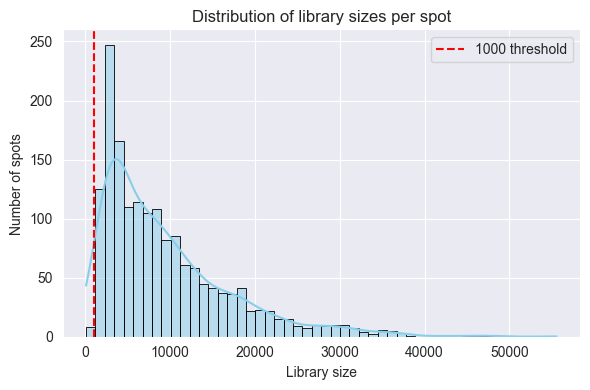

In [1173]:
# This plot shows the distribution of library sizes (total counts per spot)
# >> graph histogram combined with a KDE (Kernel Density Estimate).
# It helps to check for potential issues such as many spots with very low counts,
# >> can indicate poor experimental output.

plt.figure(figsize=(6, 4))

sns.histplot(
    adata.obs["total_counts"],
    bins=BIN_SIZE,
    kde=True,
    color="skyblue",
    edgecolor="black"
)

plt.xlabel("Library size")
plt.ylabel("Number of spots")
plt.axvline(LIB_TH, color="red", linestyle="--", label=str(LIB_TH) + " threshold")
plt.title("Distribution of library sizes per spot")
plt.legend()
sns.despine()
plt.tight_layout()

plt.savefig(os.path.join("figures/show/qc/" + DATA_FOLDER_NAME + "/", "library_size.distribution.png"), format="png", dpi=300)
plt.show()
plt.close()

This histogram indicates that there are no unusually high numbers of spots with low gene expression. Nevertheless, we set a **read count threshold = LIB_TH** to filter out these low-quality spots.

In [1174]:
# Select library size threshold
qc_lib_size = adata.obs['total_counts'] < LIB_TH  # Boolean mask: True for spots below LIBRARY_SIZE_TH reads

# Check how many spots will be filtered out
print(qc_lib_size.value_counts())

total_counts
False    1649
True        7
Name: count, dtype: int64


Totally 7 spots removed out of 1656 spots (0.42%).
total_counts
False    1649
True        7
Name: count, dtype: int64


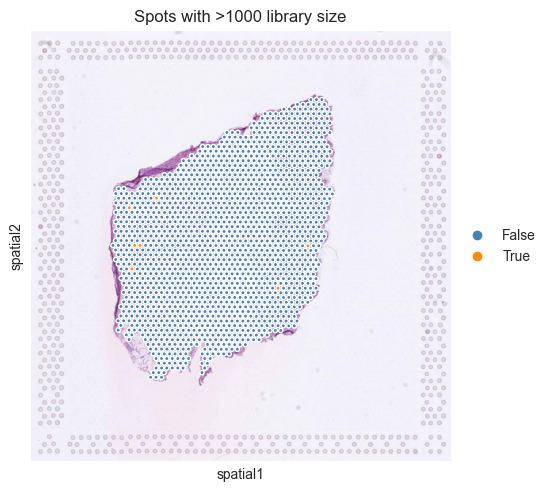

In [1175]:
# Convert boolean mask to categorical
adata.obs['qc_lib_size'] = qc_lib_size.astype("category")

# Create a ListedColormap for True/False
cmap = ListedColormap(["steelblue", "darkorange"])  # False -> grey, True -> red

# Plot spatial scatter
sq.pl.spatial_scatter(
    adata,
    color='qc_lib_size',
    palette=cmap, # Pass as ListedColormap
    size=1.2,
    title='Spots with >' + str(LIB_TH) + ' library size'
)

plt.savefig(os.path.join("figures/show/qc/" + DATA_FOLDER_NAME + "/", "library_size.filtered.png"), dpi=300, bbox_inches='tight')

rem = adata.obs['qc_lib_size'].astype(bool).sum()
tot = len(adata)
print(f"Totally {rem} spots removed out of {tot} spots ({rem/tot:.2%}).")
print(qc_lib_size.value_counts())

/var/folders/n1/v7nxdxqs1qq7ck0bphkynr1c0000gp/T/ipykernel_2093/4101099580.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  fig = sc.pl.spatial(


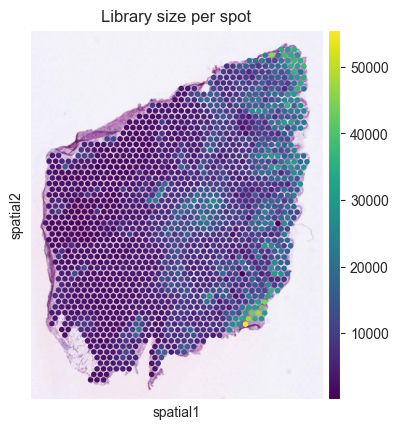

In [1176]:
fig = sc.pl.spatial(
    adata,
    color="total_counts",
    cmap="viridis",
    size=1.3,
    title="Library size per spot",
    show=False,
    return_fig=True
)

# Save the figure
fig.savefig(
    f"figures/show/qc/{DATA_FOLDER_NAME}/library_size.total_counts.png",
    dpi=300,
    bbox_inches="tight"
)

**2.1.4 Number of expressed genes**

This section visualizes the **distribution of detected (expressed) genes** across all spots.

In the next plot, we calculate the number of genes expressed in each spot and display it as a *histogram* with an overlaid *density curve*.

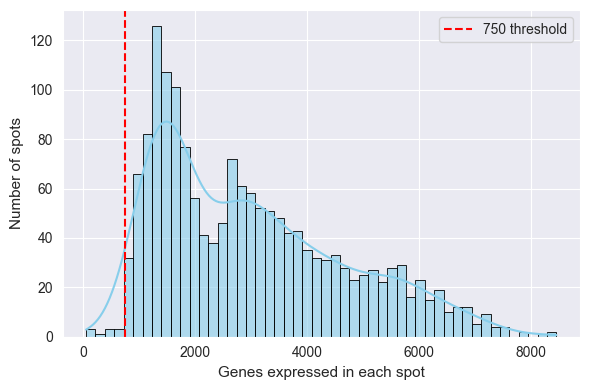

In [1177]:
# Plot
plt.figure(figsize=(6, 4))

sns.histplot(
    adata.obs['n_genes_by_counts'],
    bins=BIN_SIZE,
    kde=True,
    color="skyblue",
    edgecolor='black',
    alpha=0.6
)

plt.xlabel("Genes expressed in each spot", fontsize=11)
plt.ylabel("Number of spots", fontsize=11)
plt.axvline(GENE_TH, color="red", linestyle="--", label=str(GENE_TH) + " threshold")
plt.tight_layout()
plt.legend()

plt.savefig(os.path.join("figures/show/qc/" + DATA_FOLDER_NAME + "/", "gene_expression.distribution.png"), format="png", dpi=300)
plt.show()

In [1178]:
# Select library size threshold
n_genes_by_counts = adata.obs['n_genes_by_counts'] < GENE_TH  # Boolean mask: True for spots below GENE_EXPRESSION_TH reads

# Check how many spots are filtered out
print(n_genes_by_counts.value_counts())

n_genes_by_counts
False    1643
True       13
Name: count, dtype: int64


Totally 13 spots removed out of 1656 spots (0.79%).
n_genes_by_counts
False    1643
True       13
Name: count, dtype: int64


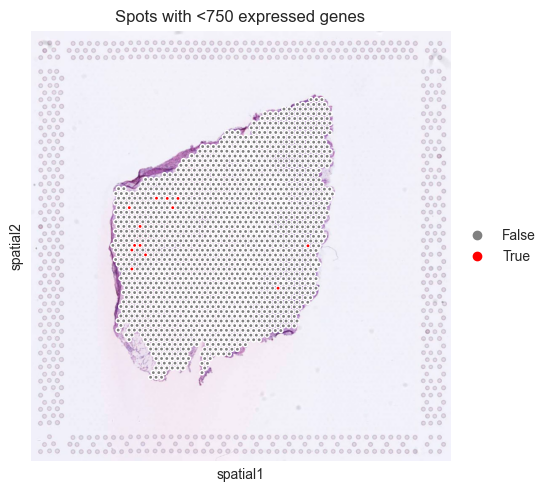

In [1179]:
# Convert boolean mask to categorical
adata.obs['n_genes_by_counts_category'] = n_genes_by_counts.astype("category")

# Create a ListedColormap for True/False
cmap = ListedColormap(["grey", "red"])  # False -> grey, True -> red

# Plot spatial scatter
sq.pl.spatial_scatter(
    adata,
    color='n_genes_by_counts_category',
    palette=cmap, # Pass as ListedColormap
    size=1.2,
    title='Spots with <' + str(GENE_TH) + ' expressed genes'
)

plt.savefig(os.path.join("figures/show/qc/" + DATA_FOLDER_NAME + "/", "gene_expression.filtered.png"), dpi=300, bbox_inches="tight")

rem = adata.obs['n_genes_by_counts_category'].astype(bool).sum()
tot = len(adata)
print(f"Totally {rem} spots removed out of {tot} spots ({rem/tot:.2%}).")
print(n_genes_by_counts.value_counts())

/var/folders/n1/v7nxdxqs1qq7ck0bphkynr1c0000gp/T/ipykernel_2093/2067715830.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  fig = sc.pl.spatial(


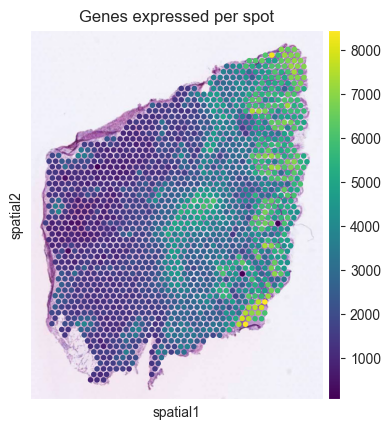

In [1180]:
fig = sc.pl.spatial(
    adata,
    color="n_genes_by_counts",
    cmap="viridis",
    size=1.3,
    title="Genes expressed per spot",
    show=False,
    return_fig=True
)

# Save the figure
fig.savefig(
    f"figures/show/qc/{DATA_FOLDER_NAME}/gene_expression.total_counts.png",
    dpi=300,
    bbox_inches="tight"
)

**2.1.5 Percentage of mitochondrial expression**

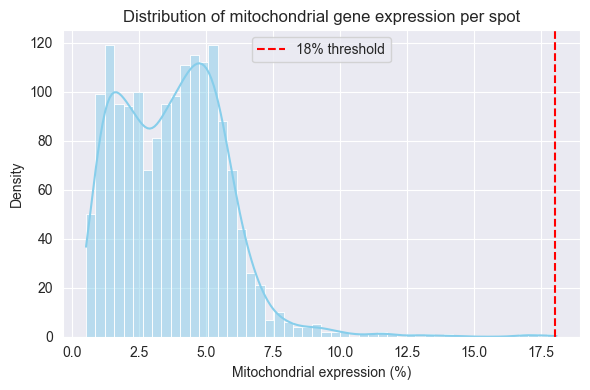

In [1181]:
# The histogram shows the distribution of the percentage of mitochondrial transcripts per spot.
# The red dashed line marks the 28% threshold (as suggested in the documentation) — spots above this value may be damaged or of poor quality.
# This plot is used for quality control and to determine how many spots exceed the acceptable limit.
plt.figure(figsize=(6,4))
sns.histplot(adata.obs["pct_counts_mt"], bins=BIN_SIZE, kde=True, color="skyblue")
plt.axvline(MITO_TH, color="red", linestyle="--", label=f"{MITO_TH}% threshold")
plt.xlabel("Mitochondrial expression (%)")
plt.ylabel("Density")
plt.title("Distribution of mitochondrial gene expression per spot")
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join("figures/show/qc/" + DATA_FOLDER_NAME + "/", "mitochondrial_gene_expression.distribution.png"), format="png", dpi=300)
plt.show()

Number of spots above the 17% mitochondrial gene threshold:
qc_mito
False    1655
True        1
Name: count, dtype: int64
Removed 1 spots (0.06% of the total).


/var/folders/n1/v7nxdxqs1qq7ck0bphkynr1c0000gp/T/ipykernel_2093/2733604459.py:17: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  fig = sc.pl.spatial(


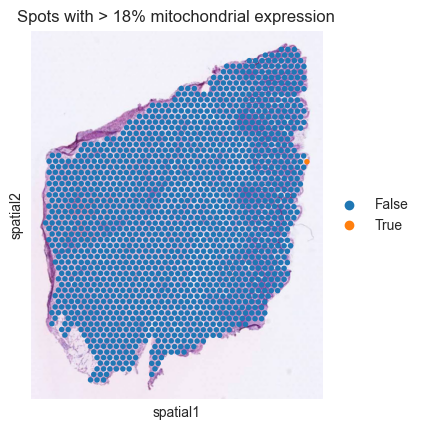

In [1182]:
# Define the threshold value (28%) and label spots above the threshold
#   - adata.obs["pct_counts_mt"] represents the percentage of mitochondrial transcripts
adata.obs["qc_mito"] = adata.obs["pct_counts_mt"] > MITO_TH

# Count how many spots are above/below the threshold
#   - True/False values correspond to spots that will be removed/retained
print("Number of spots above the 17% mitochondrial gene threshold:")
print(adata.obs["qc_mito"].value_counts())

# Percentage representation
total_spots = len(adata)
removed = adata.obs["qc_mito"].sum()
print(f"Removed {removed} spots ({removed/total_spots:.2%} of the total).")

# Visualization of the spatial distribution of spots above the threshold
#   - The sc.pl.spatial function can be used to display the spatial map
fig = sc.pl.spatial(
    adata,
    color="qc_mito",   # True/False mitochondrial filter flag
    title="Spots with > " + str(MITO_TH) + "% mitochondrial expression",
    cmap="coolwarm",
    size=1.3,
    show=False,
    return_fig=True
)

# Save figure
fig.savefig(
    f"figures/show/qc/{DATA_FOLDER_NAME}/mitochondrial_gene_expression.filtered.png",
    dpi=300,
    bbox_inches="tight"
)

**Spatial visualization**

/var/folders/n1/v7nxdxqs1qq7ck0bphkynr1c0000gp/T/ipykernel_2093/2959018578.py:6: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  fig = sc.pl.spatial(


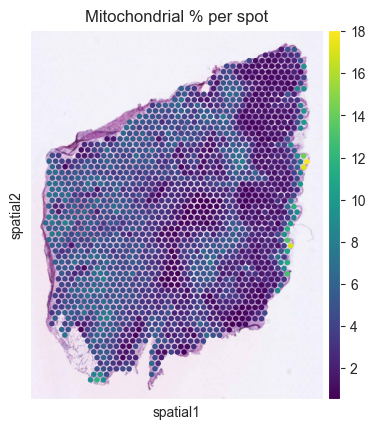

In [1183]:
# Scanpy can directly display spatial maps with selected metrics.
# This allows checking whether certain tissue regions show locally increased
# mitochondrial transcript levels (e.g., at the edges of the tissue section).

# Display a spatial plot for the selected QC metric within the tissue
fig = sc.pl.spatial(
    adata,
    color="pct_counts_mt",
    cmap="viridis",
    size=1.3,
    title="Mitochondrial % per spot",
    show=False,
    return_fig=True
)

# Save the figure
fig.savefig(
    f"figures/show/qc/{DATA_FOLDER_NAME}/mitochondrial_gene_expression.total_counts.png",
    dpi=300,
    bbox_inches="tight"
)

**2.1.6 Number of cells per spot**

In [1184]:
print(adata.obs.columns)

Index(['in_tissue', 'array_row', 'array_col', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'qc_lib_size', 'n_genes_by_counts_category', 'qc_mito'],
      dtype='object')


Information about the number of cells is not available.


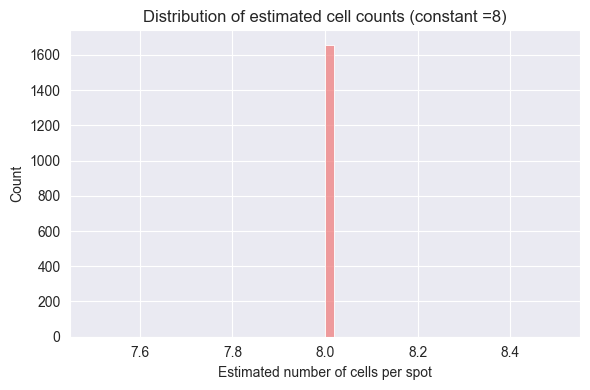

In [1185]:
# In datasets from the 10x Genomics Visium technology, the exact number of cells per spot is not known.
# The authors of the study by Valdeolivas et al., npj Precision Oncology (2024),
# used the deconvolution model Cell2Location with the parameter:
#   cells_per_spot = 8
# meaning they assumed an average of 8 cells per spot.
#
# This value is used here as a *constant estimate* for all spots.
# It is not an experimentally measured value but a model-based assumption
# derived from the literature.

# If the dataset does not contain a column with the number of cells, create it
if "cell_count" not in adata.obs.columns:
    # Set the number of cells to 8 for all spots (constant value)
    adata.obs["cell_count"] = 8

# Visualization of the cell count distribution
plt.figure(figsize=(6, 4))
sns.histplot(adata.obs["cell_count"], bins=BIN_SIZE, color="lightcoral")
plt.xlabel("Estimated number of cells per spot")
plt.ylabel("Count")
plt.title(f"Distribution of estimated cell counts (constant =8)")
plt.tight_layout()

plt.savefig(os.path.join("figures/show/qc/" + DATA_FOLDER_NAME + "/", "estimated_cells_per_spot.png"), dpi=300, bbox_inches="tight")
plt.show()


/var/folders/n1/v7nxdxqs1qq7ck0bphkynr1c0000gp/T/ipykernel_2093/3770248440.py:8: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  fig = sc.pl.spatial(


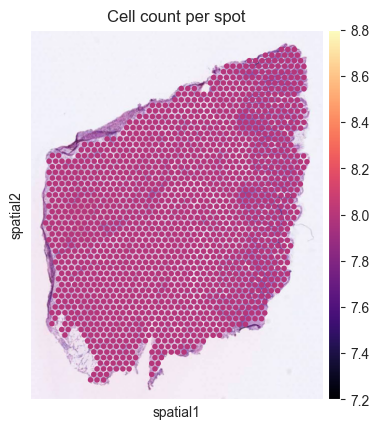

In [1186]:
import os
import matplotlib.pyplot as plt
import scanpy as sc

# ensure output folder exists
os.makedirs(f"figures/show/qc/{DATA_FOLDER_NAME}", exist_ok=True)

fig = sc.pl.spatial(
    adata,
    color="cell_count",
    cmap="magma",
    size=1.3,
    title="Cell count per spot",
    show=False,
    return_fig=True
)

fig.savefig(
    f"figures/show/qc/{DATA_FOLDER_NAME}/cell_count_per_spot.png",
    dpi=300,
    bbox_inches="tight"
)


Since we now have the estimated number of cells, we can plot the graphs shown in the documentation. However, because the cell count per spot is only an estimated value, these plots do not have strong interpretative significance.

/Users/polakova/PycharmProjects/IV114_ST/.venv/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


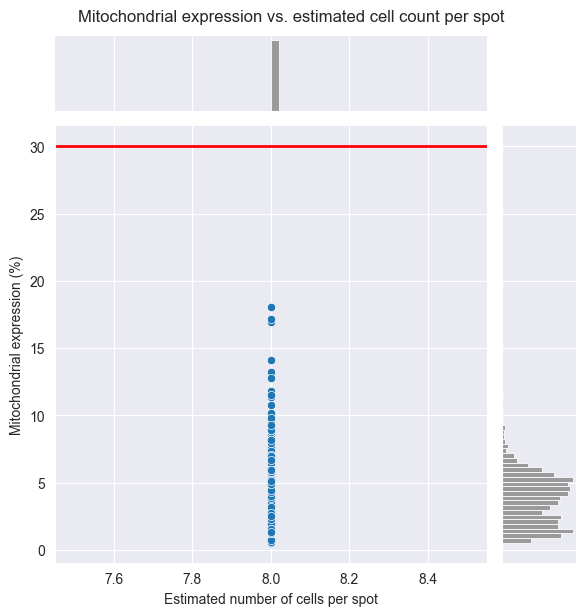

In [1187]:
# Mitochondrial expression vs. estimated number of cells
g = sns.jointplot(
    data=adata.obs,
    x="cell_count",
    y="pct_counts_mt",  # if your column name differs, adjust accordingly
    kind="scatter",
    marginal_kws=dict(bins=BIN_SIZE, fill=True, color="gray")
)

# Add a smooth trend line (LOESS)
sns.regplot(
    data=adata.obs,
    x="cell_count",
    y="pct_counts_mt",
    scatter=False,
    lowess=True,
    color="blue",
    ax=g.ax_joint
)

# Red line – threshold of 30% mitochondrial expression
g.ax_joint.axhline(30, color="red", linewidth=2)

g.ax_joint.set_xlabel("Estimated number of cells per spot")
g.ax_joint.set_ylabel("Mitochondrial expression (%)")
g.fig.suptitle("Mitochondrial expression vs. estimated cell count per spot", y=1.02)

plt.savefig(os.path.join("figures/show/qc/" + DATA_FOLDER_NAME + "/", "mitochondrial_expression_vs_estimated_cell_count.png"), dpi=300, bbox_inches="tight")
plt.show()


/Users/polakova/PycharmProjects/IV114_ST/.venv/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


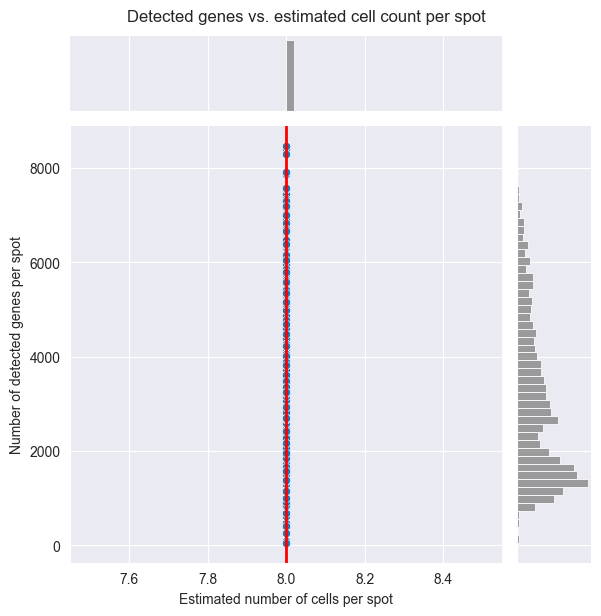

In [1188]:
# Number of detected genes vs. estimated number of cells
# (your column may be named 'n_genes_by_counts' or 'detected')
g2 = sns.jointplot(
    data=adata.obs,
    x="cell_count",
    y="n_genes_by_counts",
    kind="scatter",
    marginal_kws=dict(bins=BIN_SIZE, fill=True, color="gray")
)

sns.regplot(
    data=adata.obs,
    x="cell_count",
    y="n_genes_by_counts",
    scatter=False,
    lowess=True,
    color="blue",
    ax=g2.ax_joint
)

# Vertical line – model-based estimate of 8 cells per spot
g2.ax_joint.axvline(8, color="red", linewidth=2)

g2.ax_joint.set_xlabel("Estimated number of cells per spot")
g2.ax_joint.set_ylabel("Number of detected genes per spot")
g2.fig.suptitle("Detected genes vs. estimated cell count per spot", y=1.02)

plt.savefig(os.path.join("figures/show/qc/" + DATA_FOLDER_NAME + "/", "detected_vs_estimated_cell_count.png"), dpi=300, bbox_inches="tight")
plt.show()


/Users/polakova/PycharmProjects/IV114_ST/.venv/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


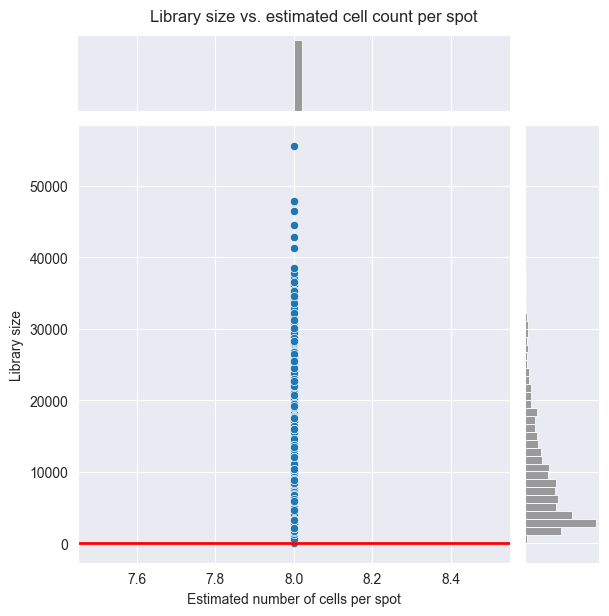

In [1189]:
# Library size vs. estimated number of cells
g = sns.jointplot(
    data=adata.obs,
    x="cell_count",
    y="total_counts",
    kind="scatter",
    marginal_kws=dict(bins=BIN_SIZE, fill=True, color="gray")
)

# Add a smooth trend line (LOESS)
sns.regplot(
    data=adata.obs,
    x="cell_count",
    y="total_counts",
    scatter=False,
    lowess=True,
    color="blue",
    ax=g.ax_joint
)

# Red line – threshold of 30% mitochondrial expression
g.ax_joint.axhline(30, color="red", linewidth=2)

g.ax_joint.set_xlabel("Estimated number of cells per spot")
g.ax_joint.set_ylabel("Library size")
g.fig.suptitle("Library size vs. estimated cell count per spot", y=1.02)

plt.savefig(os.path.join("figures/show/qc/" + DATA_FOLDER_NAME + "/", "library_size_vs_estimated_cell_count.png"), dpi=300, bbox_inches="tight")
plt.show()

**2.1.7 Remove low-quality spots**

In [1190]:
# QC thresholds are typically determined based on data distribution or literature.
# Here, we use fixed values consistent with the documentation:
#   - more than 28% mitochondrial expression = low quality
#   - more than 10 cells = low quality

/var/folders/n1/v7nxdxqs1qq7ck0bphkynr1c0000gp/T/ipykernel_2093/1195343388.py:20: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  fig = sc.pl.spatial(



Number of discarded spots: 14


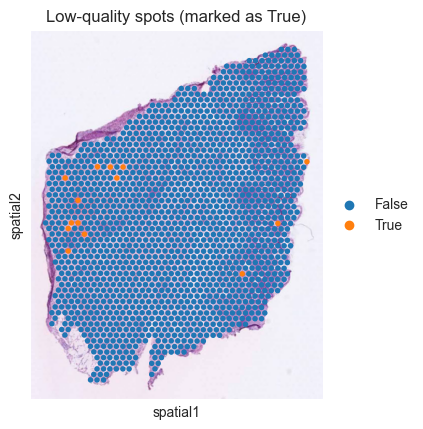

In [1191]:
# Mark spots that do not meet QC criteria
# Spots with a low total number of reads (below the defined threshold)
adata.obs["qc_low_library"] = adata.obs["total_counts"] < LIB_TH
# Spots with a low number of detected genes
adata.obs["qc_low_genes"] = adata.obs["n_genes_by_counts"] < GENE_TH
# Spots with an excessively high proportion of mitochondrial transcripts
adata.obs["qc_high_mito"] = adata.obs["pct_counts_mt"] > MITO_TH
# Spots with too many cells
adata.obs["qc_high_cells"] = adata.obs["cell_count"] > CELL_TH

adata.obs["qc_discard"] = (
    adata.obs["qc_low_library"]
    | adata.obs["qc_low_genes"]
    | adata.obs["qc_high_mito"]
    | adata.obs["qc_high_cells"]
)

print("\nNumber of discarded spots:", adata.obs["qc_discard"].sum())
# Display a spatial plot for the selected QC metric within the tissue
fig = sc.pl.spatial(
    adata,
    color="qc_discard",
    size=1.3,
    title="Low-quality spots (marked as True)",
    show=False,
    return_fig=True
)

# Save figure
fig.savefig(
    f"figures/show/qc/{DATA_FOLDER_NAME}/qc.filtered.png",
    dpi=300,
    bbox_inches="tight"
)


 **Saving the results of the QC analysis**

In [1192]:
# Filter the dataset – remove low-quality spots
adata_qc = adata[~adata.obs["qc_discard"]].copy()
print("Number of spots after QC:", adata_qc.n_obs)

# Save the results to a folder
output_dir = os.path.join("output_datasets/" + DATA_FOLDER_NAME)
os.makedirs(output_dir, exist_ok=True)
adata_qc.write(os.path.join(output_dir, "adata_QC_filtered.h5ad"))

Number of spots after QC: 1642


/Users/polakova/PycharmProjects/IV114_ST/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## NORMALIZATION
- **Normalization** in spatial transcriptomics accounts for differences in library size (UMIs per spot) to remove systematic effects unrelated to biology.  
- **Log-transformation** stabilizes variance and makes expression changes symmetrical.  


count    1642.000000
mean        1.000000
std         0.803026
min         0.141243
25%         0.377995
50%         0.778975
75%         1.339648
max         5.790454
Name: library_factors, dtype: float64

Plot histogram + density of library size factors


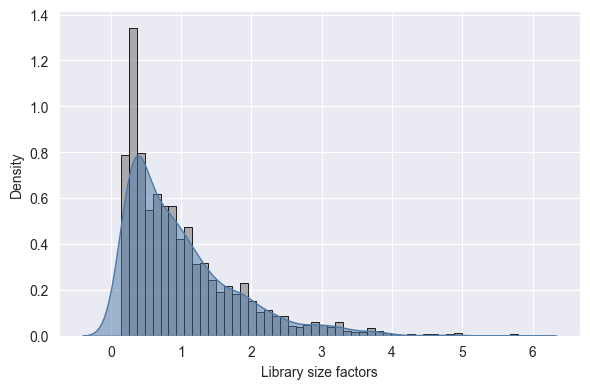


KeysView(Layers with keys: )
✅ QC processing completed. Results saved in: figures/show/qc/SN124_A798015_Rep2


In [1193]:
# Need to correct the library size by scaling the sizes across all spots such that the mean library size is 1
sc.pp.normalize_total(adata_qc, target_sum=1e6, inplace=True)  # This scales counts so that each spot has the same total counts (total_sum=1e6 is default value by documentation)

#
library_factors = adata_qc.obs['total_counts'] / adata_qc.obs['total_counts'].mean()
adata_qc.obs['library_factors'] = library_factors
print(adata_qc.obs["library_factors"].describe())

# Plot histogram + density of library size factors
print("\nPlot histogram + density of library size factors")
plt.figure(figsize=(6, 4))
sns.histplot(adata_qc.obs["library_factors"], stat="density", bins=BIN_SIZE, color="grey", edgecolor="black", alpha=0.6)
sns.kdeplot(adata_qc.obs["library_factors"], fill=True, alpha=0.5, color="#4E79A7", bw_adjust=1.0)
plt.xlabel("Library size factors")
plt.ylabel("Density")
plt.tight_layout()
sns.despine()
plt.show()

# Applaying log-transformation to the scaled counts
print()
sc.pp.log1p(adata_qc)
print(adata_qc.layers.keys())

adata_qc.write(os.path.join(output_dir, "adata_QC_filtered.normalized.h5ad"))

print(f"✅ QC processing completed. Results saved in: {save_dir}")
